Методы основанные на статистических признаках, признаках их ЭЭГ и признаках Воронцова-Успенского

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.cross_validation import LabelKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Считывание данных

In [2]:
true_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_true"))
false_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_false"))

In [ ]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

In [ ]:
def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        a = read_frame(directory, i)
        frames.append([a, patient])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

In [ ]:
true_frames = get_frames("ibs_true", true_files)
false_frames = get_frames("ibs_false", false_files)

In [ ]:
def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs})
    return df

In [ ]:
a = create_data_frame(true_frames, True)
b = create_data_frame(false_frames, False)

In [ ]:
df = a.append(b).copy()

In [ ]:
df = shuffle(df, random_state=27)
df = df.reset_index()

In [ ]:
df["SignalLen"] = df["S"].apply(lambda x: len(x))
df = df[df["SignalLen"] != 0].copy()

Предобработка данных

In [ ]:
N  = 2   # Filter order
Wn = 0.05 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
df["FS"] = df["S"].apply(lambda x : signal.filtfilt(B, A, x))

In [ ]:
df["S_Squared"] = df["S"].apply(lambda x : x * x)
df["FS_Squared"] = df["FS"].apply(lambda x : x * x)

Признаки, основанные на статистических характеристиках

In [ ]:
percentile_list = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]) * 100

In [ ]:
def get_sum_g(x, i):
    x = x.copy()
    x[x < i] = 0
    return np.sum(x)

def get_sum_l(x, i):
    x = x.copy()
    x[x >= i] = 0
    return np.sum(x)

def get_sum_g2(xf, x, i):
    x = x.copy()
    x[xf < i] = 0
    return np.sum(x)

def get_sum_l2(xf, x, i):
    x = x.copy()
    x[xf >= i] = 0
    return np.sum(x)

def get_percentile_features(df, col, p):
    df = df.copy()
    
    df[col + "_" + str(int(p))] = df[col].apply(lambda x: np.percentile(x, p))
    
    df[col + "_" + str(int(p)) + "sg"] = df[[col, col + "_" + str(int(p))]].apply(lambda x: get_sum_g(x[0], x[1]), axis=1)
    df[col + "_" + str(int(p)) + "sl"] = df[[col, col + "_" + str(int(p))]].apply(lambda x: get_sum_l(x[0], x[1]), axis=1)
    df[col + "_" + str(int(p)) + "sg2"] = df[[col, col + "_Squared", col + "_" + str(int(p))]].apply(lambda x: get_sum_g2(x[0], x[1], x[2]), axis=1)
    df[col + "_" + str(int(p)) + "sl2"] = df[[col, col + "_Squared", col + "_" + str(int(p))]].apply(lambda x: get_sum_l2(x[0], x[1], x[2]), axis=1)
    
    return df

In [ ]:
def create_stat_features(df, col, percentile_list, verbose):
    df = df.copy()
    df[col+"_mean"] = df[col].apply(lambda x: np.mean(x))
    df[col+"_std"] = df[col].apply(lambda x: np.std(x))
    df[col+"_min"] = df[col].apply(lambda x: np.min(x))
    df[col+"_max"] = df[col].apply(lambda x: np.max(x))
    
    for p in tqdm(percentile_list, "Percentile Features, " + col):
        df = get_percentile_features(df, col, p)
        
    for i in range(0, len(percentile_list)):
        for k in range(i+1, len(percentile_list)):
            first = str(int(percentile_list[i]))
            second = str(int(percentile_list[k]))
            df[col+"_" + first + "-" + second] = df[col + "_" + first] - df[col + "_" + second]
            
    x = df[col] - df[col+"_mean"]
    df[col + "_Skew"] = x.apply(lambda z : (z * z * z).mean() / (np.power((z * z).mean(), 1.5)))
    df[col + "_Kurt"] = x.apply(lambda z : (z * z * z * z).mean() / (np.power((z * z).mean(), 2.0)) - 3)

    return df

Признаки, которые используют в ЭЭГ

In [ ]:
def get_activity(array):
    return np.power(np.std(array), 2)

def create_Hjorth_features(array):
    activity = get_activity(array)
    derivative = np.diff(array)
    dactivity = get_activity(derivative)
    d2 = np.diff(derivative)
    d2activity = get_activity(d2)
    
    mobility = np.sqrt(dactivity / activity)
    dmobility = np.sqrt(d2activity / dactivity)
    
    complexity = dmobility / mobility
    
    return activity, mobility, complexity

def create_EEG_features(df, col):
    tqdm.pandas(desc="EEG Features, " + col)
    
    z = df[col].progress_apply(create_Hjorth_features)
    
    HjorthDF = pd.DataFrame(data = np.asarray(z.values.tolist()), 
                            index = df.index, 
                            columns = [col + "_Activity", col + "_Mobility", col + "_Complexity"])
    
    df = pd.concat([df, HjorthDF], axis = 1)
    
    return df

Вычисление R-пиков и признаков Ворнцова Успенского

In [ ]:
def create_peaks_features(df, col):
    df = df.copy()
    
    tqdm.pandas(desc="Peaks Features, " + col)
    
    df[col + "_RPeaks"] = df[col].progress_apply(lambda x: ecg.hamilton_segmenter(x)["rpeaks"])
    df[col + "_FirstRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: x[0])
    df[col + "_LastRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: x[len(x)-1])
    df[col + "_MedianRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: np.median(x))
    return df

In [ ]:
def get_vu_dict():
    letters = ["a", "b", "c", "d", "e",  "f"]
    d = {}
    for i in letters:
        for j in letters:
            for k in letters:
                d[i + j + k] = 0
    return d  

In [ ]:
def get_r_t_alpha(r_peaks, signal):
    drn_s = []
    tn_s = []
    alphan_s = []
    for i in range(len(r_peaks)-1):
        dr = signal[r_peaks[i+1]] - signal[r_peaks[i]]
        t = r_peaks[i+1] - r_peaks[i]
        alpha = math.atan(signal[r_peaks[i]]* 1.0 / t)
        drn_s.append(dr)
        tn_s.append(t)
        alphan_s.append(alpha)
        
    dtn_s = []
    dalpha_s = []
    
    for i in range(len(tn_s)-1):
        dtn_s.append(tn_s[i+1] - tn_s[i])
        dalpha_s.append(alphan_s[i+1] - alphan_s[i])
    return (drn_s, dtn_s, dalpha_s)  

In [ ]:
def get_seq(rn, tn, an):
    s = []
    for i in range(len(tn)):
        if (rn[i] >= 0) and (tn[i] >= 0) and (an[i] >= 0):
            s.append("a")
        elif (rn[i] < 0) and (tn[i] < 0) and (an[i] >= 0):
            s.append("b")
        elif (rn[i] >= 0) and (tn[i] < 0) and (an[i] >= 0):
            s.append("c")
        elif (rn[i] < 0) and (tn[i] >= 0) and (an[i] < 0):
            s.append("d")
        elif (rn[i] >= 0) and (tn[i] >= 0) and (an[i] < 0):
            s.append("e")
        elif (rn[i] < 0) and (tn[i] < 0) and (an[i] < 0):
            s.append("f")
    return s

In [ ]:
def get_trigram_counts(s):
    d = get_VU_dict()
    for i in range(len(s) - 2):
        d[s[i] + s[i+1] + s[i+2]] += 1
    return d

In [ ]:
def get_VU(r, s):
    k = get_r_t_alpha(r, s)
    s = get_seq(k[0], k[1], k[2])
    d = get_trigram_counts(s)
    return d

In [ ]:
def get_VU_df(df, rpeaks, signal, pr):
    df = df.copy()
    df["VU_dict"] = df[[rpeaks, signal]].apply(lambda x : get_VU(x[0], x[1]), axis=1)
    keys = get_VU_dict().keys()
    for k in sorted(keys):
        df[pr + "_VU_" + k] = df["VU_dict"].apply(lambda x: x[k])
    df.drop("VU_dict", axis=1, inplace=True)
    return df

In [ ]:
def create_features(df, percentile_list):
    df = create_peaks_features(df, "S")
    df = create_peaks_features(df, "FS")
    
    df = create_stat_features(df, "FS", percentile_list, verbose = False)
    
    df = create_EEG_features(df, "S")
    df = create_EEG_features(df, "FS")
    
    df = get_VU_df(df, "S_RPeaks", "S", "S")
    df = get_VU_df(df, "FS_RPeaks", "FS", "FS")
    
    return df

In [ ]:
df = create_features(df, percentile_list)

In [ ]:
df.drop(["S", "FS", "S_Squared", "FS_Squared"], axis = 1).to_csv("features.csv")

In [2]:
df = pd.read_csv("features.csv")

In [3]:
df.columns = [column.replace(".", "_") for column in df.columns]

In [4]:
from sklearn.cross_validation import train_test_split

Обучение классификаторов

In [5]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [9]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

In [12]:
cv = LabelKFold(df["Patient"], n_folds=20)

In [13]:
def cv_tt(df, target, cv):
    tt = []
    train_data = df.drop(target, axis = 1)
    y = df[target]
    for itrain, itest in cv:
        fold = {"xtrain" : train_data.loc[itrain,:], "ytrain" : y[itrain], 
                "xtest" : train_data.loc[itest,:], "ytest" : y[itest]}
        tt.append(fold)
    return tt

In [33]:
cv_train_test = cv_tt(df, "ibs", cv)

In [15]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tr, pr_tr, p_tst, pr_tst

In [36]:
def cv_fit_predict(clf, cv_tt, f_l, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold["xtrain"][f_l], fold["ytrain"], 
                                      fold["xtest"][f_l], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

Функция для распечатки результата

In [191]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [43]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

In [90]:
l_cv = list(cv)

Линейная комбинация различных алгоритмов

In [172]:
def patient_score(df, pr):
    df = df.copy()
    lsp = np.linspace(0, 1, 201)
    p = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df["ibs"] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() 
         for l in lsp]
    tmax = np.argmax(p)
    return p[tmax]

In [173]:
def linear_combination(df, res1, res2, cv):
    l_cv = list(cv)
    cv_answer = []
    print len(res1)
    for j in tqdm(range(len(res1))):
        print j
        scores = []
        for i in tqdm(np.arange(0, 1.005, 0.01)):
            y_pr = [a["pr_test"] * 1.0 * i  + (1-i) * 1.0 * b["pr_test"] for a, b in zip(res1[:j] + res1[j+1:],
                                                   res2[:j] + res2[j+1:])]
            s = [i, 1-i, [patient_score(df.loc[tst[1],:], pr) 
                          for pr, tst in  zip(y_pr, l_cv[:j] + l_cv[j+1:])]]
            scores.append(s)
        b = sorted(scores, key = lambda x: np.array(x[2]).mean())
        print np.mean(b[len(b)-1][2])
        alpha = b[len(b)-1][0]
        print alpha
        pr_tst = alpha * res1[j]["pr_test"] + (1.0-alpha) * res2[j]["pr_test"]
        answer = {"p_test" : None, "pr_test" : pr_tst}
        cv_answer.append(answer)
    return cv_answer

In [45]:
def add_feature_clf(cv_tt, clf_res, feature_name):
    for fold, res  in zip(cvtt, clf_res):
        fold["xtrain"][feature_name] = res["pr_train"]
        fold["xtest"][feature_name] = res["pr_test"]

In [46]:
vu_columns = [i for i in df.columns if i.startswith("S_VU")]

In [47]:
lr_f = ['FS_min', 'FS_max', 
        'FS_5',
        'FS_10', 'FS_10sl2', 
        'FS_25',
        'FS_50', 'FS_50sl', 
        'FS_75', 'FS_75sg', 'FS_75sl', 'FS_75sl2', 
        'FS_90',
        'FS_95', 'FS_95sg', 'FS_95sg2', 
        'FS_Skew', 'FS_Kurt', 
        'S_Activity', 'S_Mobility', 'S_Complexity', 
        'FS_Activity', 'FS_Mobility', 'FS_Complexity',
         u'FS_FirstRPeaks'] 
lr_f += VU_columns

In [48]:
lrclf_params = {"C": 0.63, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, cv_train_test, lr_f, lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, df.shape[0])

roc-auc = 0.795452492693
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.720554272517
Качество по людям = 0.784585598292
Наилучшее разбиение происходит при границе 0.52
Качество по сигналам = 0.726492906631
Качество по людям = 0.786747419678


0.78674741967811757

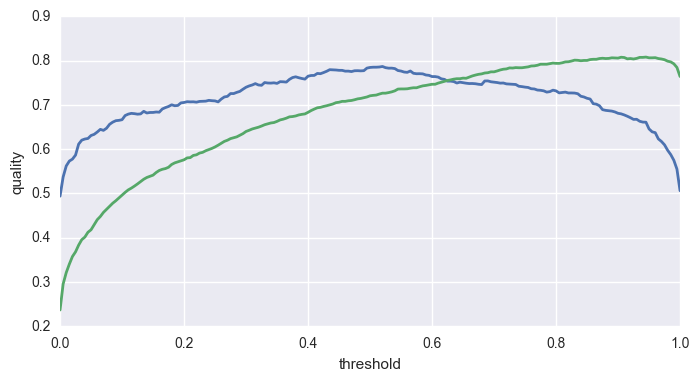

In [69]:
review(df, lr_p, lr_pr, "ibs")

Отбор только тех признаков для xgboost, которые имеют ненулевые веса в лог регресси

In [70]:
lrclf = LogisticRegression(**lrclf_params)
lrclf.fit(df[lr_f], df["ibs"], **lrfit_params)
coefs = lrclf.coef_[0]
lr_featuresfiltered = np.array(lr_f)[coefs != 0]

In [73]:
xgb_f = lr_featuresfiltered

In [81]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":3, "learning_rate":0.01,
                 "n_estimators": 1000, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"error", "early_stopping_rounds":90000, "verbose":True}
xgb_res = cv_fit_predict(xgb.XGBClassifier, cvtraintest, xgb_f, xgbclf_params, xgbfit_params, do_scaling = True, xgbfit = True)
xgb_a, xgb_pr = combine_results(xgb_res, cv, df.shape[0])

  0%|          | 0/20 [00:00<?, ?it/s]

[0]	validation_0-error:0.298105	validation_1-error:0.623476
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.298105	validation_1-error:0.623476
[2]	validation_0-error:0.224421	validation_1-error:0.365854
[3]	validation_0-error:0.219789	validation_1-error:0.362805
[4]	validation_0-error:0.219789	validation_1-error:0.362805
[5]	validation_0-error:0.273263	validation_1-error:0.611281
[6]	validation_0-error:0.219789	validation_1-error:0.362805
[7]	validation_0-error:0.219789	validation_1-error:0.362805
[8]	validation_0-error:0.219789	validation_1-error:0.362805
[9]	validation_0-error:0.219789	validation_1-error:0.364329
[10]	validation_0-error:0.219368	validation_1-error:0.5
[11]	validation_0-error:0.219368	validation_1-error:0.376524
[12]	validation_0-error:0.219368	validation_1-error:0.5
[13]	validation_0-error:0.217263	validation_1-error:0.498476
[1

  5%|▌         | 1/20 [00:07<02:26,  7.69s/it]

[0]	validation_0-error:0.286421	validation_1-error:0.753731
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.286421	validation_1-error:0.753731
[2]	validation_0-error:0.286421	validation_1-error:0.753731
[3]	validation_0-error:0.286421	validation_1-error:0.753731
[4]	validation_0-error:0.221377	validation_1-error:0.686567
[5]	validation_0-error:0.217573	validation_1-error:0.701493
[6]	validation_0-error:0.221377	validation_1-error:0.686567
[7]	validation_0-error:0.220997	validation_1-error:0.791045
[8]	validation_0-error:0.210727	validation_1-error:0.78607
[9]	validation_0-error:0.209205	validation_1-error:0.778607
[10]	validation_0-error:0.211107	validation_1-error:0.783582
[11]	validation_0-error:0.210346	validation_1-error:0.78607
[12]	validation_0-error:0.211868	validation_1-error:0.793532
[13]	validation_0-error:0.209966	validation_1-error:0.7

 10%|█         | 2/20 [00:15<02:16,  7.61s/it]

[0]	validation_0-error:0.370093	validation_1-error:0.253275
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.276231	validation_1-error:0.043668
[2]	validation_0-error:0.274447	validation_1-error:0.039301
[3]	validation_0-error:0.280871	validation_1-error:0.048035
[4]	validation_0-error:0.275161	validation_1-error:0.039301
[5]	validation_0-error:0.280871	validation_1-error:0.048035
[6]	validation_0-error:0.275874	validation_1-error:0.039301
[7]	validation_0-error:0.277659	validation_1-error:0.039301
[8]	validation_0-error:0.274447	validation_1-error:0.039301
[9]	validation_0-error:0.275161	validation_1-error:0.039301
[10]	validation_0-error:0.274447	validation_1-error:0.039301
[11]	validation_0-error:0.275874	validation_1-error:0.039301
[12]	validation_0-error:0.238401	validation_1-error:0.026201
[13]	validation_0-error:0.239472	validation_1-error:0

 15%|█▌        | 3/20 [00:22<02:09,  7.62s/it]

[0]	validation_0-error:0.225061	validation_1-error:0.16092
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.254113	validation_1-error:0.201149
[2]	validation_0-error:0.221911	validation_1-error:0.166667
[3]	validation_0-error:0.246762	validation_1-error:0.206897
[4]	validation_0-error:0.235912	validation_1-error:0.183908
[5]	validation_0-error:0.255863	validation_1-error:0.212644
[6]	validation_0-error:0.233812	validation_1-error:0.183908
[7]	validation_0-error:0.249913	validation_1-error:0.212644
[8]	validation_0-error:0.254463	validation_1-error:0.212644
[9]	validation_0-error:0.249913	validation_1-error:0.212644
[10]	validation_0-error:0.249562	validation_1-error:0.137931
[11]	validation_0-error:0.251663	validation_1-error:0.212644
[12]	validation_0-error:0.249913	validation_1-error:0.137931
[13]	validation_0-error:0.250963	validation_1-error:0.

 20%|██        | 4/20 [00:30<02:03,  7.72s/it]

[0]	validation_0-error:0.269419	validation_1-error:0.080925
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.269769	validation_1-error:0.080925
[2]	validation_0-error:0.227082	validation_1-error:0.040462
[3]	validation_0-error:0.236179	validation_1-error:0.046243
[4]	validation_0-error:0.238279	validation_1-error:0.109827
[5]	validation_0-error:0.227082	validation_1-error:0.040462
[6]	validation_0-error:0.223583	validation_1-error:0.040462
[7]	validation_0-error:0.227432	validation_1-error:0.040462
[8]	validation_0-error:0.227432	validation_1-error:0.040462
[9]	validation_0-error:0.223933	validation_1-error:0.040462
[10]	validation_0-error:0.223933	validation_1-error:0.040462
[11]	validation_0-error:0.227782	validation_1-error:0.040462
[12]	validation_0-error:0.223933	validation_1-error:0.040462
[13]	validation_0-error:0.231631	validation_1-error:0

 25%|██▌       | 5/20 [00:38<01:55,  7.72s/it]

[0]	validation_0-error:0.386026	validation_1-error:0.607143
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.271878	validation_1-error:0.621429
[2]	validation_0-error:0.271878	validation_1-error:0.621429
[3]	validation_0-error:0.271878	validation_1-error:0.621429
[4]	validation_0-error:0.271878	validation_1-error:0.621429
[5]	validation_0-error:0.382912	validation_1-error:0.607143
[6]	validation_0-error:0.271878	validation_1-error:0.621429
[7]	validation_0-error:0.354894	validation_1-error:0.621429
[8]	validation_0-error:0.26496	validation_1-error:0.621429
[9]	validation_0-error:0.354894	validation_1-error:0.621429
[10]	validation_0-error:0.316154	validation_1-error:0.621429
[11]	validation_0-error:0.313732	validation_1-error:0.614286
[12]	validation_0-error:0.306122	validation_1-error:0.635714
[13]	validation_0-error:0.305431	validation_1-error:0.

 30%|███       | 6/20 [00:46<01:50,  7.88s/it]

[0]	validation_0-error:0.303638	validation_1-error:0.466667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.262496	validation_1-error:0.644444
[2]	validation_0-error:0.262496	validation_1-error:0.633333
[3]	validation_0-error:0.257735	validation_1-error:0.633333
[4]	validation_0-error:0.262836	validation_1-error:0.633333
[5]	validation_0-error:0.262836	validation_1-error:0.633333
[6]	validation_0-error:0.248215	validation_1-error:0.633333
[7]	validation_0-error:0.257735	validation_1-error:0.633333
[8]	validation_0-error:0.244815	validation_1-error:0.633333
[9]	validation_0-error:0.250255	validation_1-error:0.677778
[10]	validation_0-error:0.233254	validation_1-error:0.677778
[11]	validation_0-error:0.244815	validation_1-error:0.666667
[12]	validation_0-error:0.230194	validation_1-error:0.666667
[13]	validation_0-error:0.242435	validation_1-error:0

 35%|███▌      | 7/20 [00:55<01:46,  8.16s/it]

[0]	validation_0-error:0.266236	validation_1-error:0.222222
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.258075	validation_1-error:0.211111
[2]	validation_0-error:0.258075	validation_1-error:0.211111
[3]	validation_0-error:0.258075	validation_1-error:0.211111
[4]	validation_0-error:0.258075	validation_1-error:0.211111
[5]	validation_0-error:0.246175	validation_1-error:0.211111
[6]	validation_0-error:0.244135	validation_1-error:0.211111
[7]	validation_0-error:0.245495	validation_1-error:0.211111
[8]	validation_0-error:0.243795	validation_1-error:0.211111
[9]	validation_0-error:0.241755	validation_1-error:0.211111
[10]	validation_0-error:0.247535	validation_1-error:0.2
[11]	validation_0-error:0.241074	validation_1-error:0.2
[12]	validation_0-error:0.248215	validation_1-error:0.2
[13]	validation_0-error:0.262156	validation_1-error:0.2
[14]	validat

 40%|████      | 8/20 [01:04<01:41,  8.44s/it]

[0]	validation_0-error:0.242095	validation_1-error:0.133333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.227814	validation_1-error:0.122222
[2]	validation_0-error:0.242095	validation_1-error:0.133333
[3]	validation_0-error:0.227814	validation_1-error:0.122222
[4]	validation_0-error:0.239714	validation_1-error:0.133333
[5]	validation_0-error:0.217273	validation_1-error:0.144444
[6]	validation_0-error:0.213193	validation_1-error:0.122222
[7]	validation_0-error:0.217613	validation_1-error:0.144444
[8]	validation_0-error:0.212513	validation_1-error:0.122222
[9]	validation_0-error:0.210473	validation_1-error:0.122222
[10]	validation_0-error:0.211833	validation_1-error:0.122222
[11]	validation_0-error:0.208433	validation_1-error:0.122222
[12]	validation_0-error:0.210133	validation_1-error:0.122222
[13]	validation_0-error:0.232914	validation_1-error:0

 45%|████▌     | 9/20 [01:13<01:34,  8.56s/it]

[0]	validation_0-error:0.295138	validation_1-error:0.577778
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.295138	validation_1-error:0.577778
[2]	validation_0-error:0.269976	validation_1-error:0.588889
[3]	validation_0-error:0.274056	validation_1-error:0.588889
[4]	validation_0-error:0.229174	validation_1-error:0.6
[5]	validation_0-error:0.242435	validation_1-error:0.588889
[6]	validation_0-error:0.243115	validation_1-error:0.588889
[7]	validation_0-error:0.241074	validation_1-error:0.588889
[8]	validation_0-error:0.241414	validation_1-error:0.588889
[9]	validation_0-error:0.241074	validation_1-error:0.588889
[10]	validation_0-error:0.241414	validation_1-error:0.588889
[11]	validation_0-error:0.241074	validation_1-error:0.588889
[12]	validation_0-error:0.241414	validation_1-error:0.588889
[13]	validation_0-error:0.241414	validation_1-error:0.5888

 50%|█████     | 10/20 [01:21<01:25,  8.56s/it]

[0]	validation_0-error:0.3254	validation_1-error:0.588889
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.289697	validation_1-error:0.633333
[2]	validation_0-error:0.284597	validation_1-error:0.644444
[3]	validation_0-error:0.274056	validation_1-error:0.644444
[4]	validation_0-error:0.264536	validation_1-error:0.655556
[5]	validation_0-error:0.239034	validation_1-error:0.744444
[6]	validation_0-error:0.251615	validation_1-error:0.722222
[7]	validation_0-error:0.239374	validation_1-error:0.733333
[8]	validation_0-error:0.248215	validation_1-error:0.711111
[9]	validation_0-error:0.247195	validation_1-error:0.722222
[10]	validation_0-error:0.246515	validation_1-error:0.711111
[11]	validation_0-error:0.244815	validation_1-error:0.7
[12]	validation_0-error:0.249915	validation_1-error:0.7
[13]	validation_0-error:0.206392	validation_1-error:0.7
[14]	vali

 55%|█████▌    | 11/20 [01:30<01:18,  8.68s/it]

[0]	validation_0-error:0.296158	validation_1-error:0.466667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.276437	validation_1-error:0.422222
[2]	validation_0-error:0.244815	validation_1-error:0.433333
[3]	validation_0-error:0.276437	validation_1-error:0.422222
[4]	validation_0-error:0.244815	validation_1-error:0.433333
[5]	validation_0-error:0.276437	validation_1-error:0.422222
[6]	validation_0-error:0.244815	validation_1-error:0.433333
[7]	validation_0-error:0.274396	validation_1-error:0.444444
[8]	validation_0-error:0.242775	validation_1-error:0.455556
[9]	validation_0-error:0.274396	validation_1-error:0.444444
[10]	validation_0-error:0.277117	validation_1-error:0.477778
[11]	validation_0-error:0.274396	validation_1-error:0.477778
[12]	validation_0-error:0.277797	validation_1-error:0.444444
[13]	validation_0-error:0.270996	validation_1-error:0

 60%|██████    | 12/20 [01:39<01:09,  8.69s/it]

[0]	validation_0-error:0.267256	validation_1-error:0.177778
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.267256	validation_1-error:0.177778
[2]	validation_0-error:0.240394	validation_1-error:0.155556
[3]	validation_0-error:0.244475	validation_1-error:0.144444
[4]	validation_0-error:0.245495	validation_1-error:0.166667
[5]	validation_0-error:0.250595	validation_1-error:0.155556
[6]	validation_0-error:0.273376	validation_1-error:0.166667
[7]	validation_0-error:0.273376	validation_1-error:0.166667
[8]	validation_0-error:0.274736	validation_1-error:0.166667
[9]	validation_0-error:0.273036	validation_1-error:0.166667
[10]	validation_0-error:0.271676	validation_1-error:0.166667
[11]	validation_0-error:0.257395	validation_1-error:0.166667
[12]	validation_0-error:0.263856	validation_1-error:0.166667
[13]	validation_0-error:0.256715	validation_1-error:0

 65%|██████▌   | 13/20 [01:48<01:01,  8.73s/it]

[0]	validation_0-error:0.260116	validation_1-error:0.411111
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.230874	validation_1-error:0.422222
[2]	validation_0-error:0.224753	validation_1-error:0.411111
[3]	validation_0-error:0.230874	validation_1-error:0.422222
[4]	validation_0-error:0.231554	validation_1-error:0.422222
[5]	validation_0-error:0.230874	validation_1-error:0.422222
[6]	validation_0-error:0.231554	validation_1-error:0.422222
[7]	validation_0-error:0.230874	validation_1-error:0.422222
[8]	validation_0-error:0.229174	validation_1-error:0.388889
[9]	validation_0-error:0.230874	validation_1-error:0.422222
[10]	validation_0-error:0.225434	validation_1-error:0.388889
[11]	validation_0-error:0.232234	validation_1-error:0.388889
[12]	validation_0-error:0.223393	validation_1-error:0.388889
[13]	validation_0-error:0.228834	validation_1-error:0

 70%|███████   | 14/20 [01:57<00:53,  8.85s/it]

[0]	validation_0-error:0.365862	validation_1-error:0.211111
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.365862	validation_1-error:0.211111
[2]	validation_0-error:0.365862	validation_1-error:0.211111
[3]	validation_0-error:0.365862	validation_1-error:0.211111
[4]	validation_0-error:0.226454	validation_1-error:0.211111
[5]	validation_0-error:0.226454	validation_1-error:0.211111
[6]	validation_0-error:0.228154	validation_1-error:0.2
[7]	validation_0-error:0.228154	validation_1-error:0.2
[8]	validation_0-error:0.247535	validation_1-error:0.177778
[9]	validation_0-error:0.248215	validation_1-error:0.177778
[10]	validation_0-error:0.240734	validation_1-error:0.188889
[11]	validation_0-error:0.243455	validation_1-error:0.177778
[12]	validation_0-error:0.241755	validation_1-error:0.177778
[13]	validation_0-error:0.230194	validation_1-error:0.166667
[1

 75%|███████▌  | 15/20 [02:06<00:44,  8.86s/it]

[0]	validation_0-error:0.300578	validation_1-error:0.511111
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.249915	validation_1-error:0.588889
[2]	validation_0-error:0.230874	validation_1-error:0.522222
[3]	validation_0-error:0.249915	validation_1-error:0.588889
[4]	validation_0-error:0.234274	validation_1-error:0.533333
[5]	validation_0-error:0.230874	validation_1-error:0.522222
[6]	validation_0-error:0.231894	validation_1-error:0.533333
[7]	validation_0-error:0.231894	validation_1-error:0.533333
[8]	validation_0-error:0.230874	validation_1-error:0.522222
[9]	validation_0-error:0.206052	validation_1-error:0.488889
[10]	validation_0-error:0.232234	validation_1-error:0.522222
[11]	validation_0-error:0.232234	validation_1-error:0.522222
[12]	validation_0-error:0.228154	validation_1-error:0.522222
[13]	validation_0-error:0.203332	validation_1-error:0

 80%|████████  | 16/20 [02:15<00:35,  8.93s/it]

[0]	validation_0-error:0.238354	validation_1-error:0.422222
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.243795	validation_1-error:0.355556
[2]	validation_0-error:0.218293	validation_1-error:0.433333
[3]	validation_0-error:0.243795	validation_1-error:0.355556
[4]	validation_0-error:0.217953	validation_1-error:0.433333
[5]	validation_0-error:0.243795	validation_1-error:0.355556
[6]	validation_0-error:0.244815	validation_1-error:0.355556
[7]	validation_0-error:0.243795	validation_1-error:0.355556
[8]	validation_0-error:0.213193	validation_1-error:0.444444
[9]	validation_0-error:0.243115	validation_1-error:0.355556
[10]	validation_0-error:0.225774	validation_1-error:0.377778
[11]	validation_0-error:0.225093	validation_1-error:0.388889
[12]	validation_0-error:0.218633	validation_1-error:0.377778
[13]	validation_0-error:0.224073	validation_1-error:0

 85%|████████▌ | 17/20 [02:24<00:26,  8.88s/it]

[0]	validation_0-error:0.247791	validation_1-error:0.426966
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.247791	validation_1-error:0.426966
[2]	validation_0-error:0.247791	validation_1-error:0.426966
[3]	validation_0-error:0.229436	validation_1-error:0.449438
[4]	validation_0-error:0.205982	validation_1-error:0.460674
[5]	validation_0-error:0.227736	validation_1-error:0.460674
[6]	validation_0-error:0.233515	validation_1-error:0.404494
[7]	validation_0-error:0.219239	validation_1-error:0.483146
[8]	validation_0-error:0.232835	validation_1-error:0.404494
[9]	validation_0-error:0.217539	validation_1-error:0.483146
[10]	validation_0-error:0.230455	validation_1-error:0.404494
[11]	validation_0-error:0.228756	validation_1-error:0.393258
[12]	validation_0-error:0.228756	validation_1-error:0.404494
[13]	validation_0-error:0.227736	validation_1-error:0

 90%|█████████ | 18/20 [02:33<00:18,  9.01s/it]

[0]	validation_0-error:0.337865	validation_1-error:0.426966
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.290619	validation_1-error:0.449438
[2]	validation_0-error:0.312033	validation_1-error:0.47191
[3]	validation_0-error:0.290279	validation_1-error:0.449438
[4]	validation_0-error:0.312033	validation_1-error:0.47191
[5]	validation_0-error:0.296057	validation_1-error:0.47191
[6]	validation_0-error:0.296057	validation_1-error:0.47191
[7]	validation_0-error:0.295037	validation_1-error:0.47191
[8]	validation_0-error:0.28552	validation_1-error:0.438202
[9]	validation_0-error:0.24949	validation_1-error:0.41573
[10]	validation_0-error:0.25051	validation_1-error:0.41573
[11]	validation_0-error:0.24949	validation_1-error:0.41573
[12]	validation_0-error:0.245411	validation_1-error:0.404494
[13]	validation_0-error:0.225357	validation_1-error:0.404494
[14]

 95%|█████████▌| 19/20 [02:42<00:08,  8.92s/it]

[0]	validation_0-error:0.298436	validation_1-error:0.269663
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.298436	validation_1-error:0.269663
[2]	validation_0-error:0.298097	validation_1-error:0.269663
[3]	validation_0-error:0.270224	validation_1-error:0.269663
[4]	validation_0-error:0.272604	validation_1-error:0.269663
[5]	validation_0-error:0.270564	validation_1-error:0.269663
[6]	validation_0-error:0.270224	validation_1-error:0.269663
[7]	validation_0-error:0.271924	validation_1-error:0.269663
[8]	validation_0-error:0.268865	validation_1-error:0.269663
[9]	validation_0-error:0.270564	validation_1-error:0.269663
[10]	validation_0-error:0.298436	validation_1-error:0.292135
[11]	validation_0-error:0.270564	validation_1-error:0.269663
[12]	validation_0-error:0.298097	validation_1-error:0.292135
[13]	validation_0-error:0.275323	validation_1-error:0

roc-auc = 0.728025078068
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.671065654899
Качество по людям = 0.782371726164
Наилучшее разбиение происходит при границе 0.515
Качество по сигналам = 0.68129330254
Качество по людям = 0.794466813419


0.79446681341947945

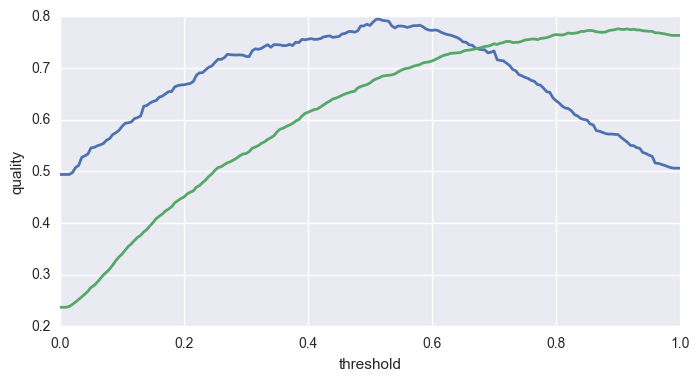

In [82]:
review(df, xgb_a, xgb_pr, "ibs")

In [174]:
cv_l = linear_combination(df, xgb_res, lr_res, cv)

  0%|          | 0/101 [00:00<?, ?it/s]

20
0


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
1


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
2


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
3


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
4


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
5


  0%|          | 0/101 [00:00<?, ?it/s]

0.892175768649
0.77
6


  0%|          | 0/101 [00:00<?, ?it/s]

0.897789149115
0.77
7


  0%|          | 0/101 [00:00<?, ?it/s]

0.893703875084
0.59
8


  0%|          | 0/101 [00:00<?, ?it/s]

0.895750743822
0.77
9


  0%|          | 0/101 [00:00<?, ?it/s]

0.899911787205
0.83
10


  0%|          | 0/101 [00:00<?, ?it/s]

0.906822226796
0.59
11


  0%|          | 0/101 [00:00<?, ?it/s]

0.908089401513
0.77
12


  0%|          | 0/101 [00:00<?, ?it/s]

0.900772491938
0.77
13


  0%|          | 0/101 [00:00<?, ?it/s]

0.900136259989
0.77
14


  0%|          | 0/101 [00:00<?, ?it/s]

0.895268287449
0.77
15


  0%|          | 0/101 [00:00<?, ?it/s]

0.900974856151
0.77
16


  0%|          | 0/101 [00:00<?, ?it/s]

0.89681146075
0.77
17


  0%|          | 0/101 [00:00<?, ?it/s]

0.902119424663
0.83
18


  0%|          | 0/101 [00:00<?, ?it/s]

0.900822239137
0.77
19


0.902632709369
0.77


Результат линейной комбинации

roc-auc = 0.76332151928
Наилучшее разбиение происходит при границе 0.5
Качество по сигналам = 0.693500494886
Качество по людям = 0.801846316229


0.80184631622882308

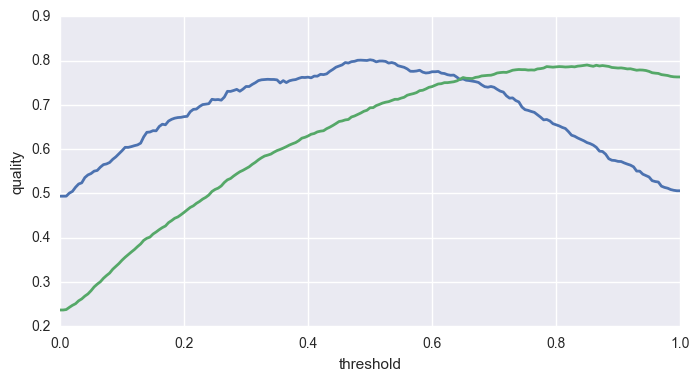

In [217]:
a, pr = combine_results(cv_l, cv, df.shape[0]) 
review(df, p=None, pr=pr)

In [218]:
rf_f = lr_featuresfiltered